In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import warnings


warnings.filterwarnings('ignore')

# Mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [2]:
import json

# Leer el JSON
with open("./datasets/clean_listings_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()}

# Carga el dataset
file_path = "./datasets/clean_listings.csv"
df_fe = pd.read_csv(file_path)



for col in categorical_cols:
    df_fe[col] = df_fe[col].astype("category")




In [3]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# neighbourhood
neighbourhood_categories = sorted(df_fe["neighbourhood_cleansed"].unique())
ordinal_encoder = OrdinalEncoder(categories=[neighbourhood_categories])
df_fe["neighbourhood_encoded"] = ordinal_encoder.fit_transform(df_fe[["neighbourhood_cleansed"]]).astype(int)
df_fe.head(10)

# room_type
room_type_categories = sorted(df_fe["room_type"].unique())
ordinal_encoder = OrdinalEncoder(categories=[room_type_categories])
df_fe["room_type_encoded"] = ordinal_encoder.fit_transform(df_fe[["room_type"]]).astype(int)
df_fe.head(10)

# property_type
property_type_categories = sorted(df_fe["property_type"].unique())
ordinal_encoder = OrdinalEncoder(categories=[property_type_categories])
df_fe["property_type_encoded"] = ordinal_encoder.fit_transform(df_fe[["property_type"]]).astype(int)

# reviews (discretización)
df_fe['reviews_bin'] = pd.qcut(df_fe['number_of_reviews'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy alto'])

# availability_365 (discreatización)
df_fe['availability_bin'] = pd.qcut(df_fe['availability_365'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy alto'])

df_fe.head(10)

host_id    price        room_type       property_type  \
0  191042082  36758.0  Entire home/apt  Entire rental unit   
1  137427072  37000.0  Entire home/apt  Entire rental unit   
2  385856273  28356.0  Entire home/apt  Entire rental unit   
3     895346  74475.0  Entire home/apt  Entire rental unit   
4  225695530  43809.0  Entire home/apt  Entire rental unit   
5  467311712  35707.0  Entire home/apt        Entire condo   
6   32973396  50263.0  Entire home/apt        Entire condo   
7  482355671  42009.0  Entire home/apt        Entire condo   
8  467311712  42009.0  Entire home/apt        Entire condo   
9   32973396  54611.0  Entire home/apt        Entire condo   

  neighbourhood_cleansed  accommodates  bedrooms  beds  minimum_nights  \
0              Agronomia             2       1.0   3.0               3   
1              Agronomia             3       0.0   2.0               3   
2              Agronomia             2       1.0   1.0               2   
3              Agronomia             4       2.0   3.0               3   
4              Agronomia             2       1.0   1.0               2   
5              Agronomia             3       1.0   2.0               4   
6              Agronomia             4       1.0   3.0               1   
7              Agronomia             3       1.0   3.0               3   
8              Agronomia             3       1.0   2.0               3   
9              Agronomia             4       1.0   4.0               3   

   maximum_nights  availability_365  number_of_reviews  review_scores_rating  \
0            1125                73                 15                  4.67   
1             180               179                 15                  4.93   
2            1125               328                 67                  4.87   
3              27               168                 17                  4.82   
4              90               364                  1                  5.00   
5            1125                14                 11                  4.82   
6             365               364                 31                  4.68   
7              90                 3                 13                  4.85   
8            1125                58                 17                  4.94   
9             365               365                 18                  4.72   

   review_scores_cleanliness  review_scores_checkin  \
0                       4.67                   5.00   
1                       4.73                   4.80   
2                       4.73                   4.93   
3                       4.94                   4.94   
4                       4.00                   4.00   
5                       4.64                   5.00   
6                       4.74                   4.84   
7                       4.62                   5.00   
8                       4.88                   5.00   
9                       4.78                   4.78   

   review_scores_communication  review_scores_location  reviews_per_month  \
0                         5.00                    5.00               0.20   
1                         4.93                    4.80               0.22   
2                         4.97                    4.88               1.39   
3                         4.88                    4.82               0.47   
4                         5.00                    4.00               0.05   
5                         5.00                    4.45               0.37   
6                         4.77                    4.71               1.36   
7                         5.00                    4.85               0.46   
8                         5.00                    4.88               0.64   
9                         4.72                    4.78               0.70   

  instant_bookable   latitude  longitude  missing_count  \
0            False -34.592970 -58.492990              0   
1            False -34.596500 -58.488490              

Nuevas variables:

In [4]:

from sklearn.cluster import KMeans

# Precio por persona
df_fe['price_per_person'] = df_fe['price'] / df_fe['accommodates']

# Precio por cama
df_fe['price_per_bed'] = df_fe['price'] / df_fe['beds'].replace(0, np.nan)

# Ratio de reviews por año
df_fe['reviews_per_year'] = df_fe['reviews_per_month'] * 12

# Precio elevado
df_fe['expensive'] = (df_fe['price'] > df_fe['price'].quantile(0.90)).astype(int)

# propiedad muy comentada (top 10%)
review_threshold = df_fe['number_of_reviews'].quantile(0.90)

# Es altamente calificado
df_fe['highly_reviewed'] = (df_fe['number_of_reviews'] >= review_threshold).astype(int)

# Log-transform para min_nights para facilitar la visualización
df_fe['min_nights_log'] = np.log1p(df_fe['minimum_nights'])

# Agrupar por barrio y aplicar KMeans dentro de cada grupo
df_fe['geo_subcluster'] = -1  # Inicializamos con un valor inválido

for neigh in df_fe['neighbourhood_cleansed'].unique():
    mask = df_fe['neighbourhood_cleansed'] == neigh
    coords = df_fe.loc[mask, ['latitude', 'longitude']]

    if len(coords) >= 10:  # Solo si hay suficientes puntos
        kmeans = KMeans(n_clusters=10, random_state=42)
        df_fe.loc[mask, 'geo_subcluster'] = kmeans.fit_predict(coords)
    else:
        # Si hay pocos puntos, los dejamos todo
        df_fe.loc[mask, 'geo_subcluster'] = 0

df_fe.head(200)

host_id    price        room_type       property_type  \
0    191042082  36758.0  Entire home/apt  Entire rental unit   
1    137427072  37000.0  Entire home/apt  Entire rental unit   
2    385856273  28356.0  Entire home/apt  Entire rental unit   
3       895346  74475.0  Entire home/apt  Entire rental unit   
4    225695530  43809.0  Entire home/apt  Entire rental unit   
..         ...      ...              ...                 ...   
195   45244004  18904.0  Entire home/apt  Entire rental unit   
196   22285522  35000.0  Entire home/apt  Entire rental unit   
197  229275787  89268.0  Entire home/apt  Entire rental unit   
198  229275787  57615.0  Entire home/apt        Entire condo   
199  229275787  89268.0  Entire home/apt  Entire rental unit   

    neighbourhood_cleansed  accommodates  bedrooms  beds  minimum_nights  \
0                Agronomia             2       1.0   3.0               3   
1                Agronomia             3       0.0   2.0               3   
2                Agronomia             2       1.0   1.0               2   
3                Agronomia             4       2.0   3.0               3   
4                Agronomia             2       1.0   1.0               2   
..                     ...           ...       ...   ...             ...   
195                Almagro             3       1.0   2.0              10   
196                Almagro             3       1.0   3.0               3   
197                Almagro             2       1.0   2.0               3   
198                Almagro             2       1.0   2.0               3   
199                Almagro             2       1.0   2.0               3   

     maximum_nights  availability_365  number_of_reviews  \
0              1125                73                 15   
1               180               179                 15   
2              1125               328                 67   
3                27               168                 17   
4                90               364                  1   
..              ...               ...                ...   
195            1125               214                  0   
196              20                64                  0   
197              30               324                  4   
198            1125               308                  4   
199            1125               311                  4   

     review_scores_rating  review_scores_cleanliness  review_scores_checkin  \
0                    4.67                       4.67                   5.00   
1                    4.93                       4.73                   4.80   
2                    4.87                       4.73                   4.93   
3                    4.82                       4.94                   4.94   
4                    5.00                       4.00                   4.00   
..                    ...                        ...                    ...   
195                  4.88                       4.84                   4.95   
196                  4.88                       4.84                   4.95   
197                  4.75                       4.50                   4.25   
198                  4.25                       4.50                   4.25   
199                  4.50                       4.25                   5.00   

     review_scores_communication  review_scores_location  reviews_per_month  \
0                           5.00                    5.00               0.20   
1                           4.93                    4.80               0.22   
2                           4.97                    4.88               1.39   
3                           4.88                    4.82               0.47   
4                           5.00                    4.00               0.05   
..                           ...                     ...                ...   
195                         4.96                    4.94               0.93   
196                    

### 2. Exploración

* ¿Cuál es la relación entre el precio y el tipo de alojamiento?

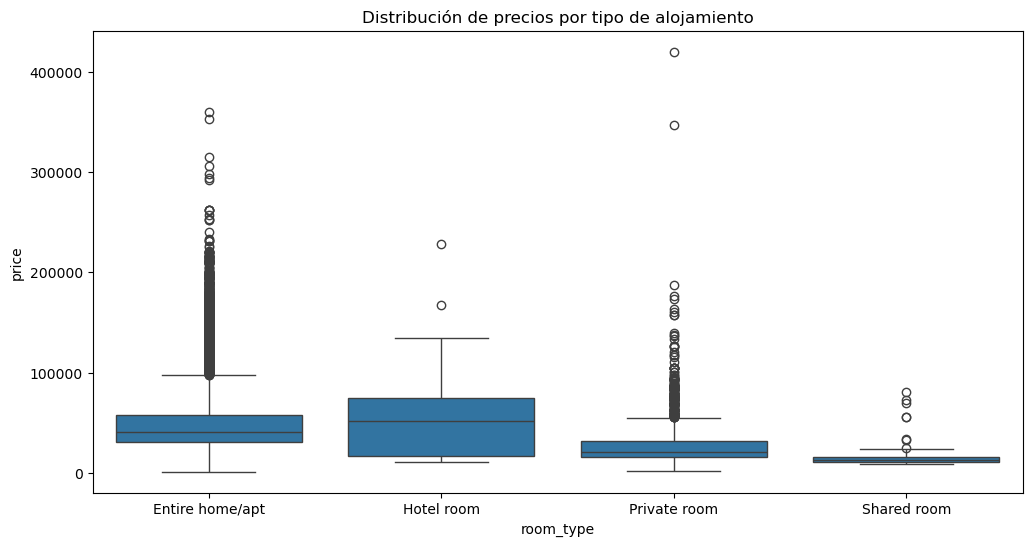

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=df_fe)
plt.title('Distribución de precios por tipo de alojamiento')
plt.show()

<AxesSubplot: xlabel='room_type', ylabel='price'>

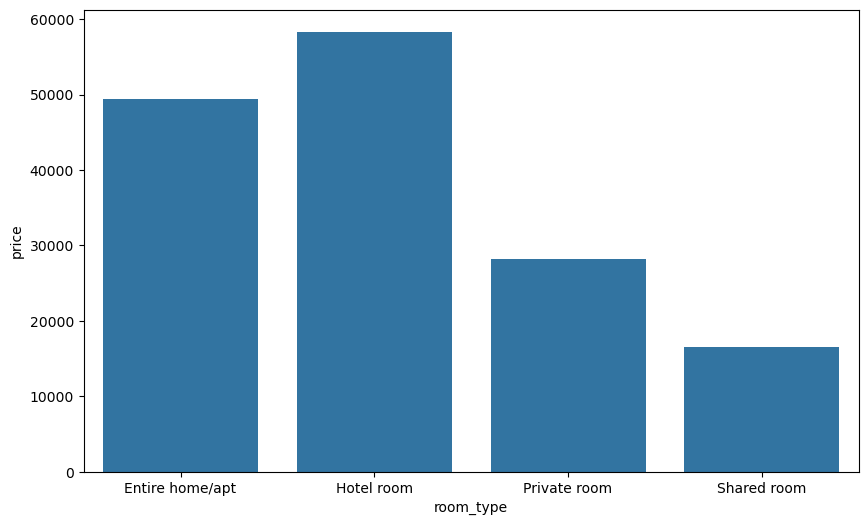

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='room_type',  
    y='price',      
    data=df_fe,    
    ci=None        
)

El precio varía significativamente dependiendo del tipo de alojamiento. Los precios más altos se observan en los hoteles y apartamentos o casas, que posiblemente se ubiquen en zonas más demandadas, además de que podrían ofrecer más servicios. Por otro lado, las habitaciones privadas y compartidas son las opciones más económicas, lo cual concuerda con la realidad.

* ¿Cómo varía la disponibilidad de las propiedades según el número de camas y
habitaciones?

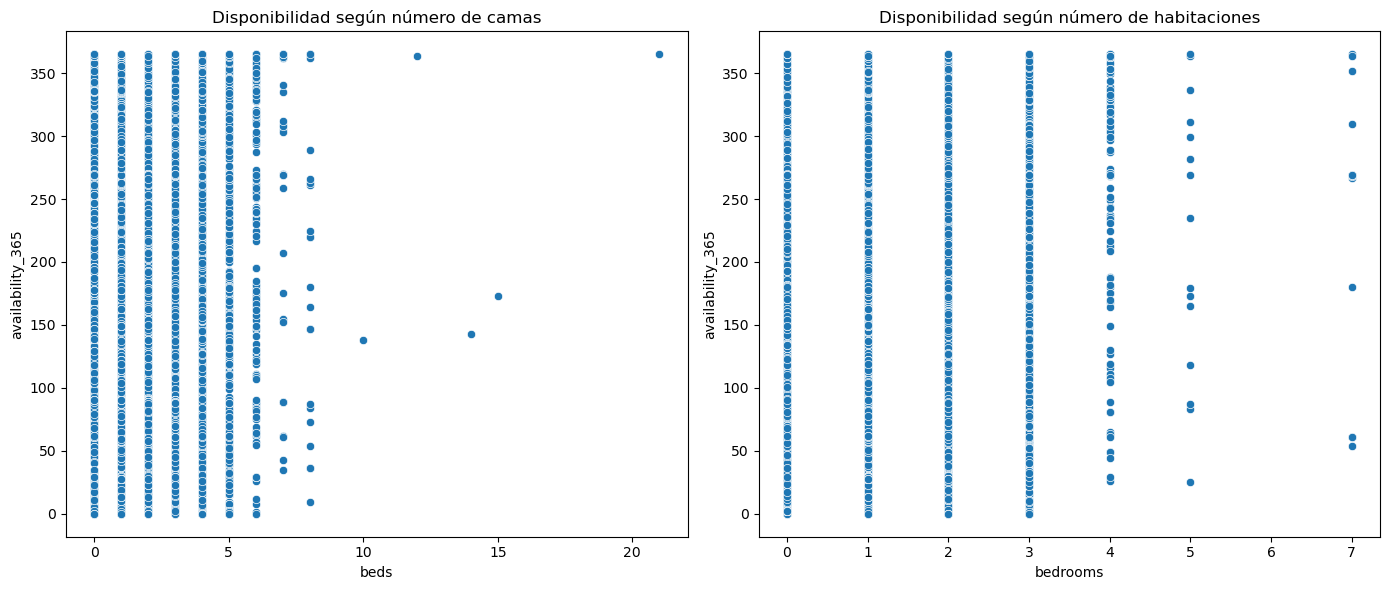

                      beds  bedrooms  availability_365
beds              1.000000  0.507979          0.020168
bedrooms          0.507979  1.000000          0.011266
availability_365  0.020168  0.011266          1.000000


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x='beds', y='availability_365', data=df_fe, ax=axes[0])
axes[0].set_title('Disponibilidad según número de camas')


sns.scatterplot(x='bedrooms', y='availability_365', data=df_fe, ax=axes[1])
axes[1].set_title('Disponibilidad según número de habitaciones')

plt.tight_layout()
plt.show()

# Correlaciones
print(df_fe[['beds', 'bedrooms', 'availability_365']].corr())


Correlación entre `beds` y `availability_365` es muy baja y positiva, lo que implica que no hay una relación fuerte entre el número de camas y la disponibilidad de la propiedad a lo largo del año. Esto indica que el número de camas no tiene un impacto significativo sobre la cantidad de días que una propiedad está disponible para reservar. 

Similar a la correlación anterior, la relación entre el número de habitaciones y la disponibilidad es muy baja. Esto refuerza la idea de que el número de habitaciones de una propiedad no influyen de manera significativa en la cantidad de días que la propiedad está disponible para alquilar.

* ¿Existen patrones de precios según la ubicación, por ejemplo, en barrios específicos?


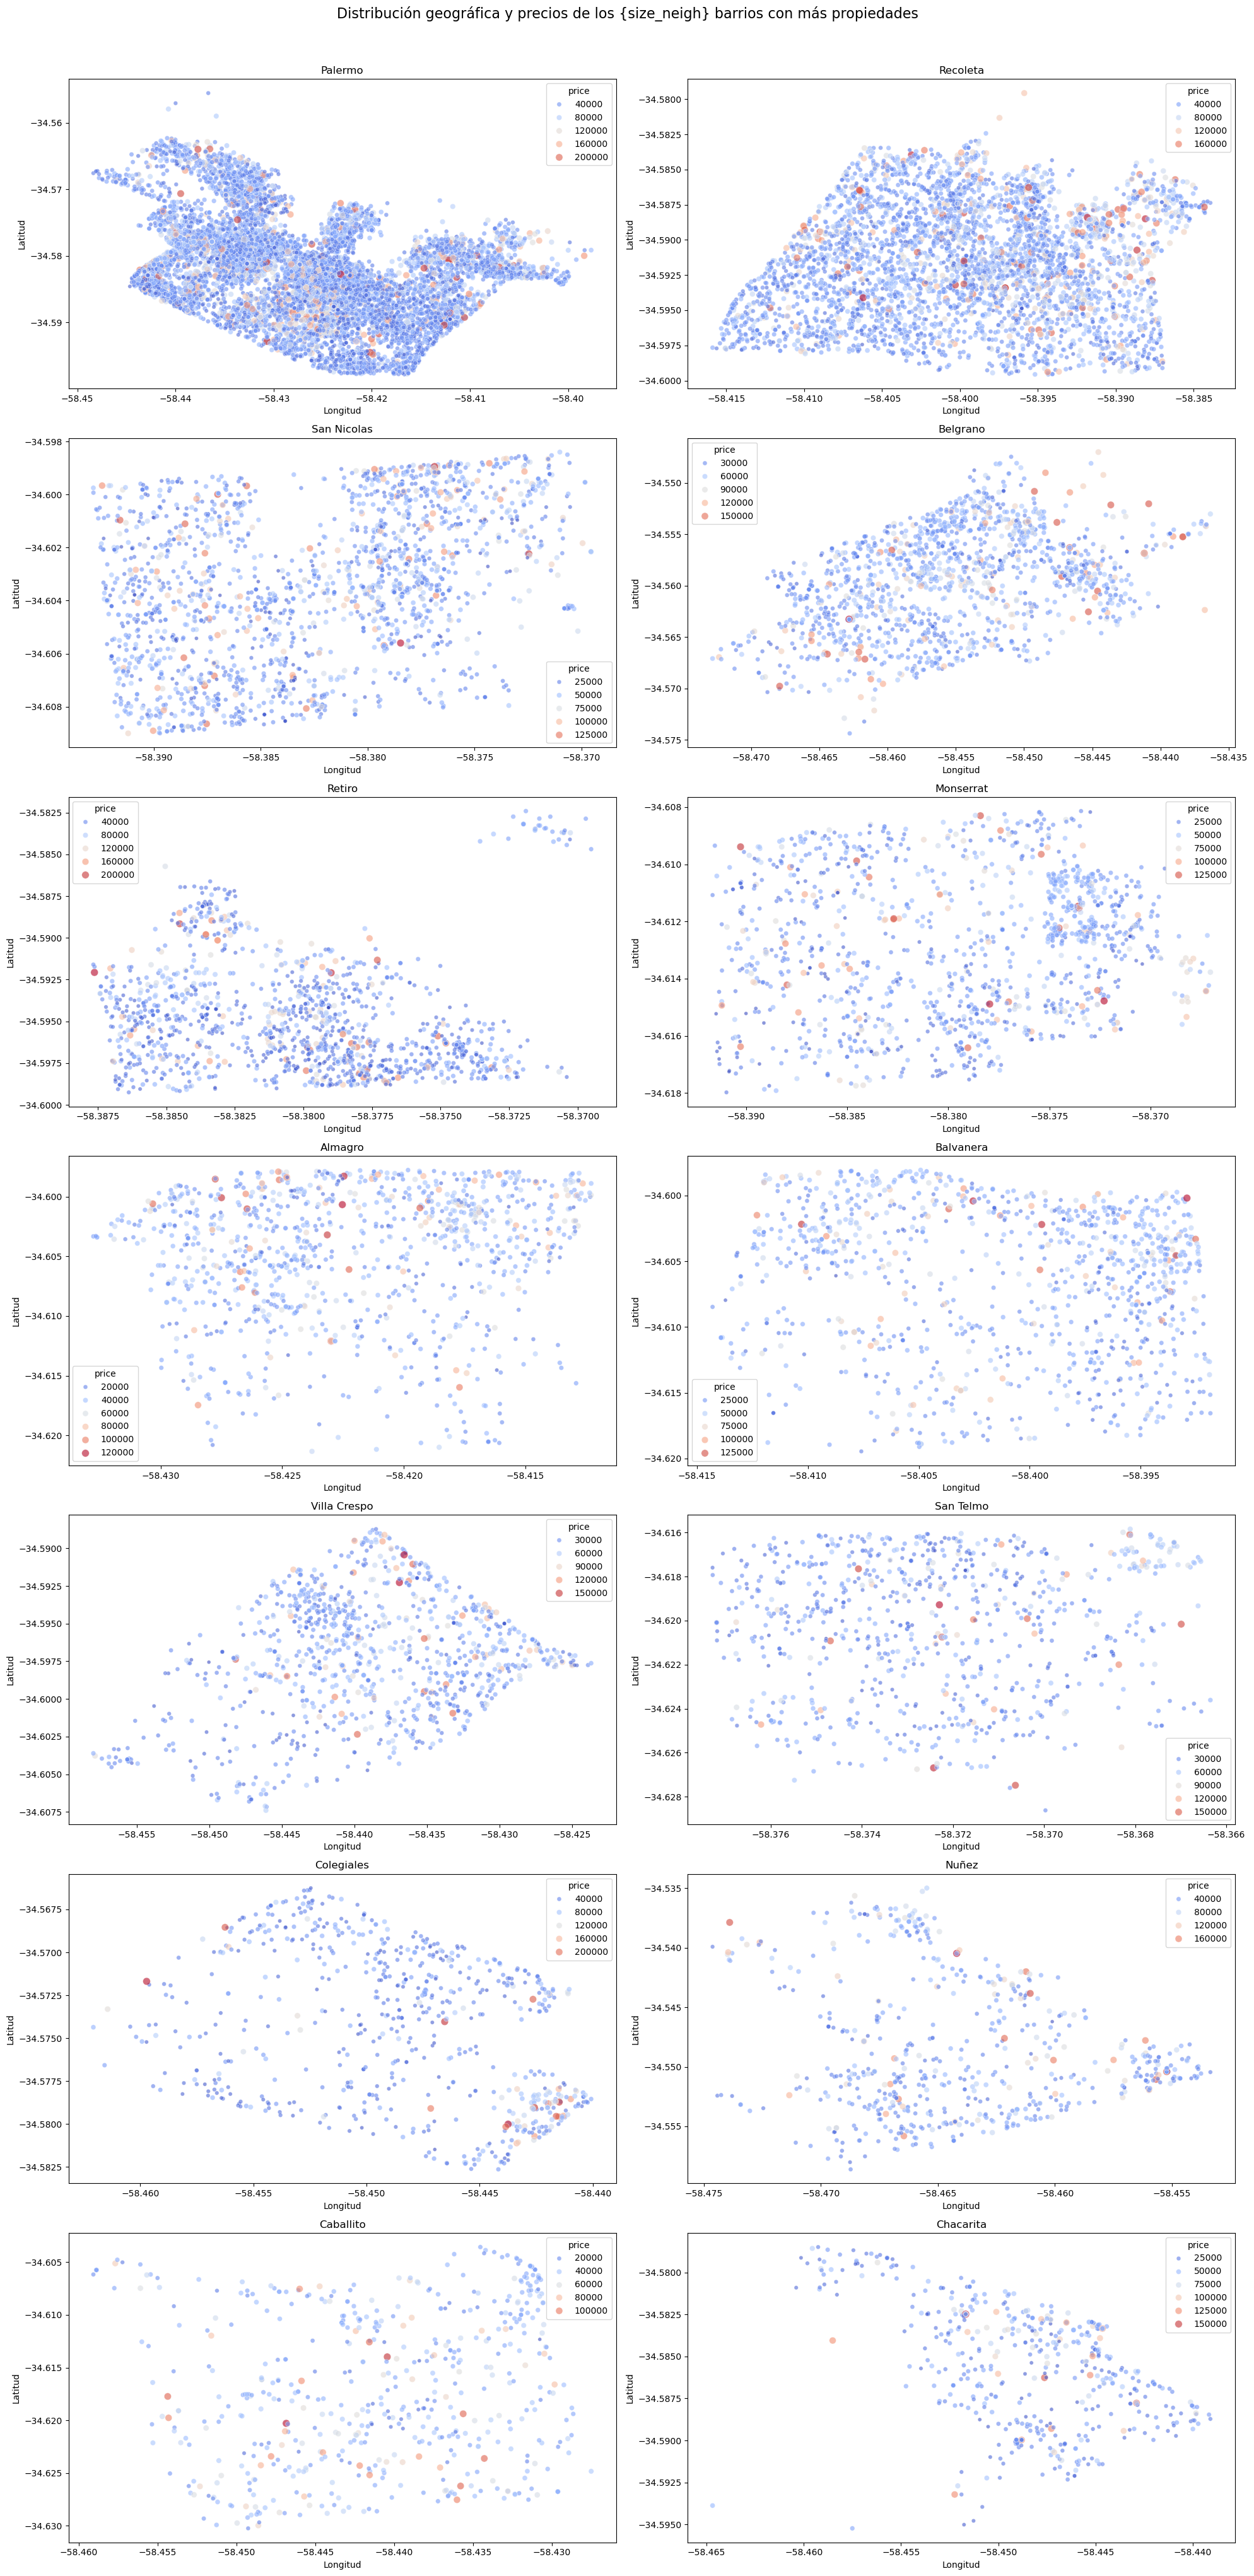

In [8]:
size_neigh = 14
top_freq = df_fe['neighbourhood_cleansed'].value_counts().head(size_neigh).index
df_freq = df_fe[df_fe['neighbourhood_cleansed'].isin(top_freq)].copy()
df_freq['neighbourhood_cleansed'] = pd.Categorical(
    df_freq['neighbourhood_cleansed'],
    categories=top_freq,
    ordered=True
)

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 40))
axes = axes.flatten()

# -- Crear un scatterplot por neighbourhood
for i, neigh in enumerate(top_freq):
    ax = axes[i]
    data = df_freq[df_freq['neighbourhood_cleansed'] == neigh]
    
    sns.scatterplot(
        data=data,
        x='longitude', y='latitude',
        hue='price',
        size='price',
        palette='coolwarm',
        alpha=0.6,
        ax=ax,
    )
    
    ax.set_title(neigh)
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')

plt.tight_layout()
plt.suptitle('Distribución geográfica y precios de los {size_neigh} barrios con más propiedades', fontsize=16, y=1.02)
plt.show()

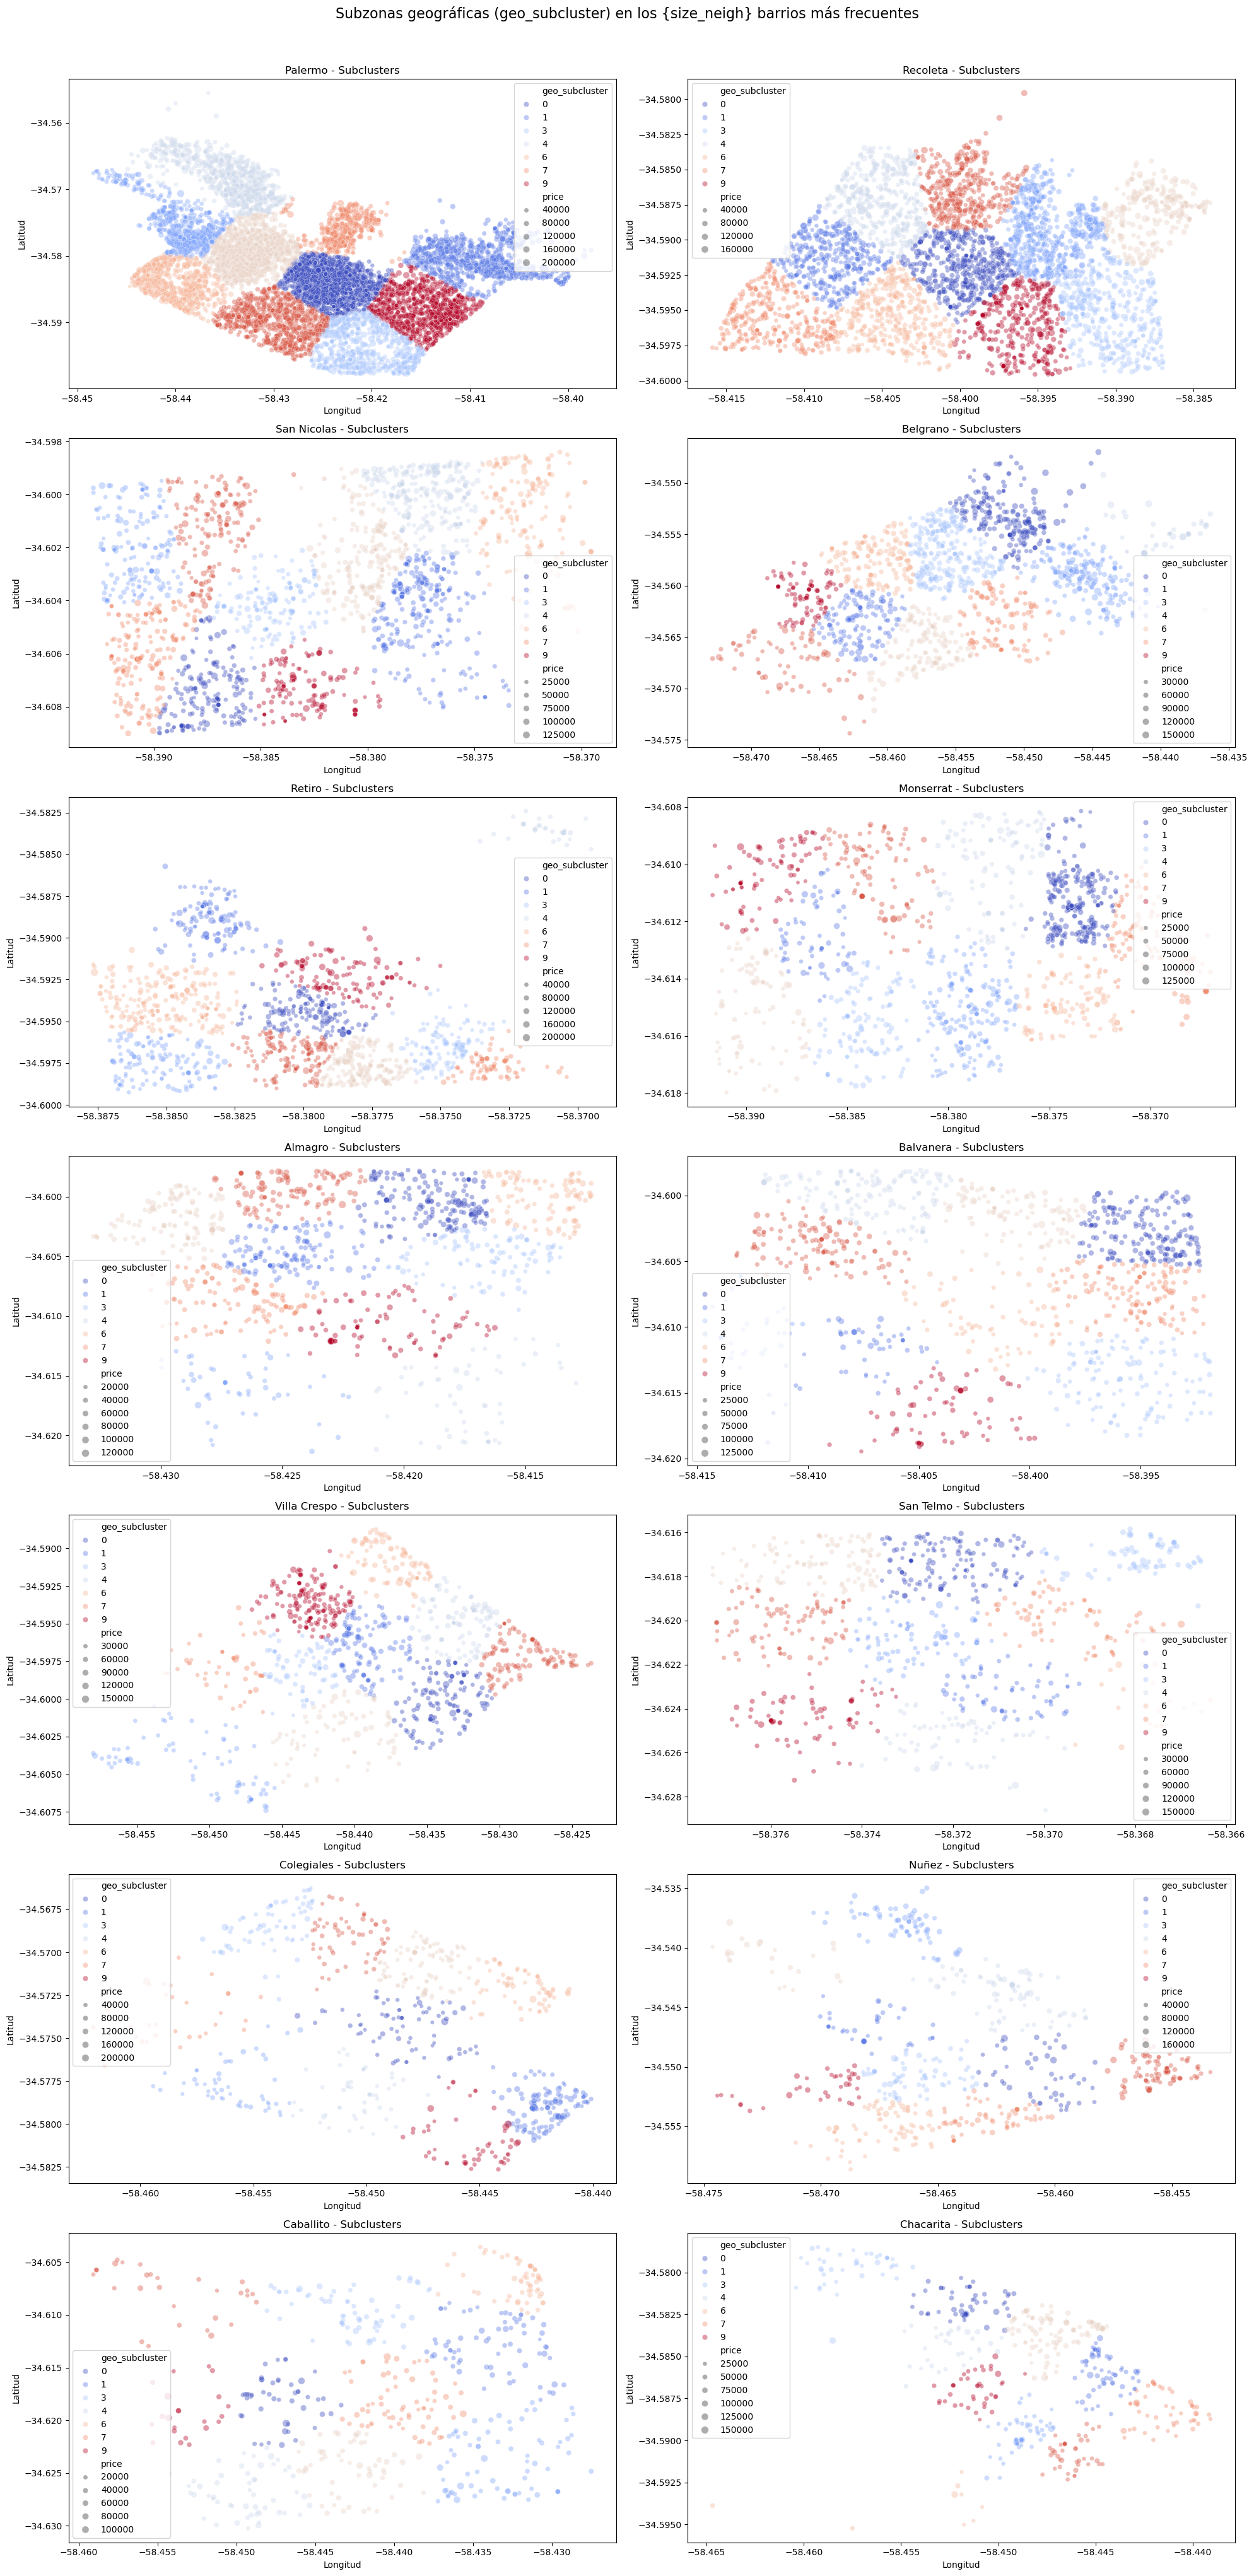

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 40))
axes = axes.flatten()

for i, neigh in enumerate(top_freq):
    ax = axes[i]
    data = df_freq[df_freq['neighbourhood_cleansed'] == neigh]

    # Normaliza precio
    norm = mcolors.Normalize(vmin=data['price'].min(), vmax=data['price'].max())
    alphas = norm(data['price'])
    
    sns.scatterplot(
        data=data,
        x='longitude', y='latitude',
        hue='geo_subcluster',
        size='price',
        palette='coolwarm',
        alpha=0.4,
        ax=ax,
    )
    
    ax.set_title(f"{neigh} - Subclusters")
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')

plt.tight_layout()
plt.suptitle('Subzonas geográficas (geo_subcluster) en los {size_neigh} barrios más frecuentes', fontsize=16, y=1.02)
plt.show()

A partir de los gráficos, se observa que ciertas áreas presentan una alta concentración de propiedades de Airbnb, lo que sugiere una fuerte demanda en estos lugares, probablemente impulsada por su proximidad a puntos turísticos clave o al centro de la ciudad. Factores como la accesibilidad, la infraestructura y la proximidad a zonas de interés también juegan un rol importante en esta concentración.

Al analizar las subzonas geográficas, se destaca que en varias de estas áreas, los precios de las propiedades tienden a ser homogéneos. Este patrón refleja la influencia de la ubicación geográfica sobre los precios, lo que indica que los precios de las propiedades no solo dependen de las características individuales de cada propiedad, sino también de la zona en la que se encuentran, revelando una correlación significativa entre la ubicación y los precios en estas subzonas.

* ¿Qué características (número de camas, tipo de propiedad, etc.) están más correlacionadas con la puntuación de los huéspedes?

                                price  accommodates  bedrooms  \
price                        1.000000      0.432507  0.388752   
accommodates                 0.432507      1.000000  0.566924   
bedrooms                     0.388752      0.566924  1.000000   
property_type_encoded       -0.175433     -0.217038 -0.018889   
room_type_encoded           -0.193699     -0.257584 -0.007793   
beds                         0.325753      0.728617  0.507979   
neighbourhood_encoded        0.046672      0.037353  0.030309   
review_scores_rating         0.048831     -0.011071 -0.011720   
review_scores_cleanliness    0.050335     -0.004338 -0.029143   
review_scores_communication  0.035931     -0.005177  0.010424   
review_scores_location       0.053643     -0.002562  0.004617   

                             property_type_encoded  room_type_encoded  \
price                                    -0.175433          -0.193699   
accommodates                             -0.217038          -0.257584   


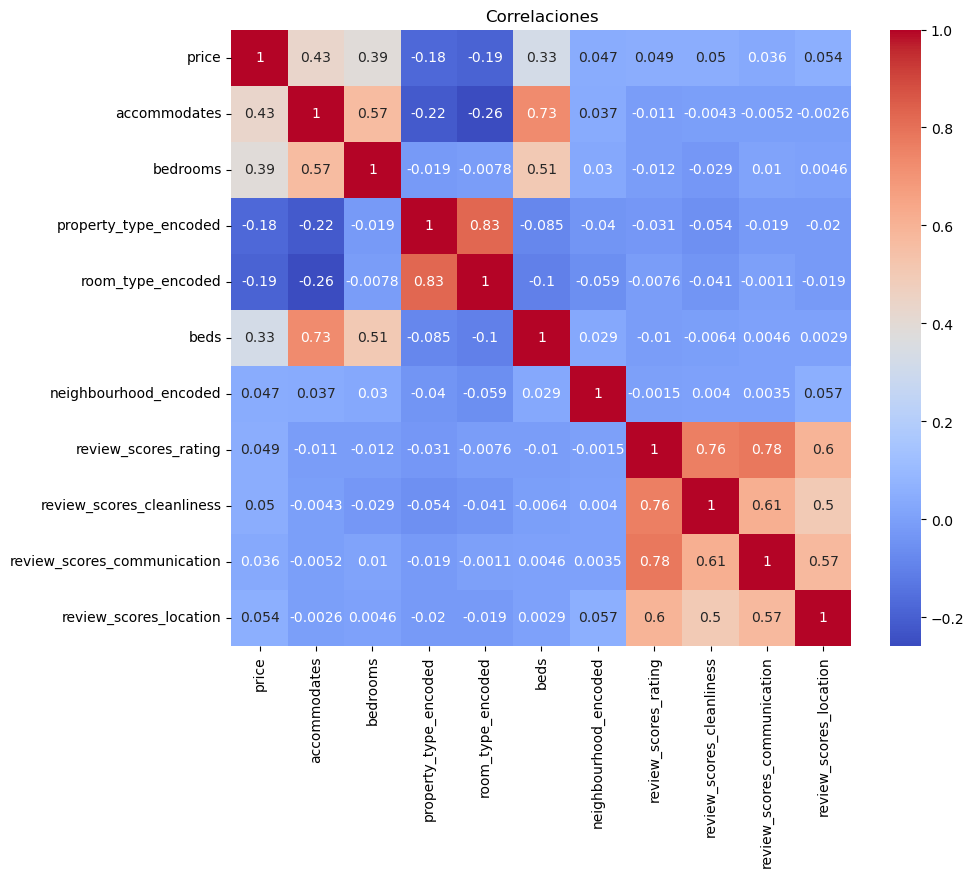

In [10]:
num_cols = [
    'price', 'accommodates', 'bedrooms', 'property_type_encoded', 'room_type_encoded',
    'beds', 'neighbourhood_encoded', 'review_scores_rating', 'review_scores_cleanliness', 
    'review_scores_communication', 'review_scores_location'
]

corr_matrix = df_fe[num_cols].corr()

print(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlaciones')
plt.show()


Las características mostradas no están fuertemente correlacionadas con las puntuaciones de los huéspedes (Basado en la observación de que las correlaciones son cercanas a 0). De esto se puede inferir que, los huéspedes no necesariamente califican la propiedad en base a las características del producto, sino que podría depender de factores más subjetivos como experiencias personales con el host, etc.

* ¿Cómo varía la distribución de precios según el tipo de propiedad y el número de
reseñas recibidas?

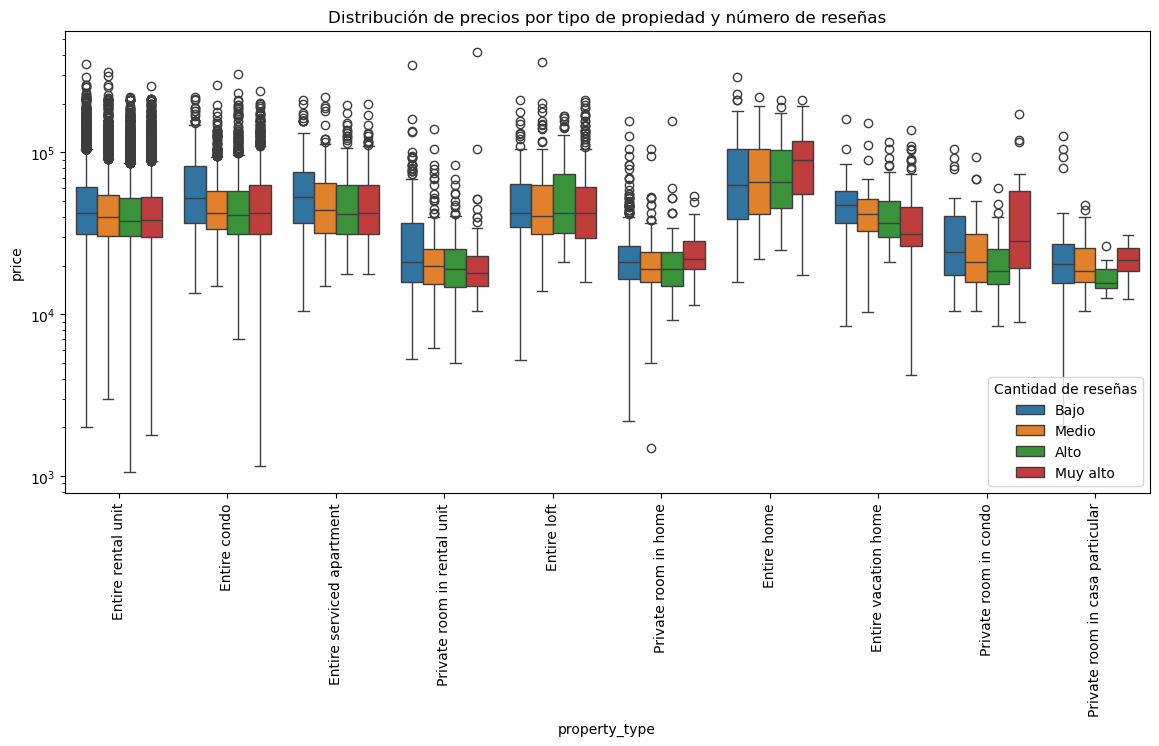

In [11]:
# Seleccionamos los 10 tipos más frecuentes
top_property_types = df_fe['property_type'].value_counts().nlargest(10).index

# Filtramos el DataFrame
df_top = df_fe[df_fe['property_type'].isin(top_property_types)]

plt.figure(figsize=(14, 6))
sns.boxplot(x='property_type', y='price', hue='reviews_bin', data=df_top, order=top_property_types)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Distribución de precios por tipo de propiedad y número de reseñas')
plt.legend(title='Cantidad de reseñas')
plt.show()

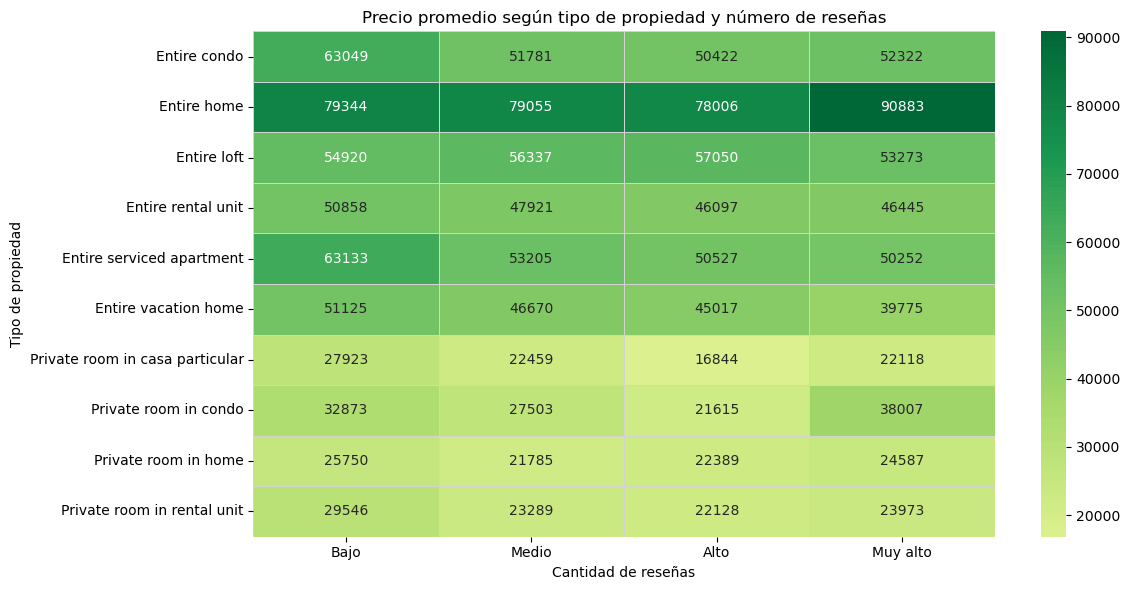

In [12]:
df_temp = df_fe.copy()

pivot = df_top.pivot_table(index='property_type', columns='reviews_bin', values='price', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="RdYlGn", center=0, linewidths=0.5, linecolor='lightgray')
plt.title('Precio promedio según tipo de propiedad y número de reseñas')
plt.xlabel('Cantidad de reseñas')
plt.ylabel('Tipo de propiedad')
plt.tight_layout()
plt.show()


A partir de las gráficas, podemos inferir que los tipos de propiedad sí afectan el precio, dado que propiedades como 'Entire condo', 'Entire home' o 'Entire loft' presentan precios promedios notablemente más altos que otras opciones como habitaciones privadad.  

Asimismo, las propiedades con más reseñas no necesariamente tiene los precios más altos. Esto podría indicar que los precios mas accesible atraen a más huéspedes, lo que incrementa la cantidad de reseñas. Asimismo, esto podría reflejar que la cantidad de reseñas depende más del tiempo que la propiedad existe en airbnb y no tanto al precio.

* ¿Cómo varía el precio según el número de noches mínimas requeridas?


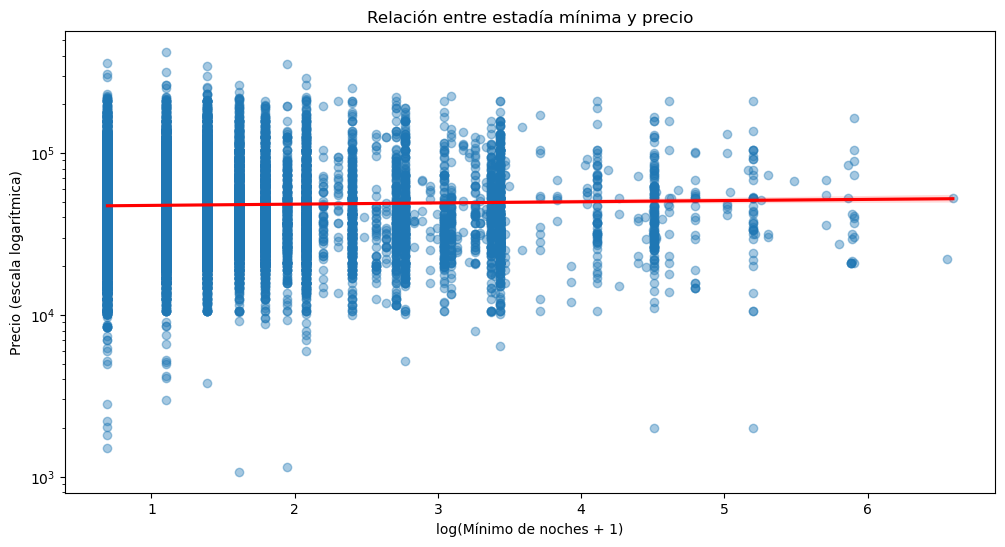

In [13]:
plt.figure(figsize=(12, 6))
#sns.scatterplot(x='min_nights_log', y='price', data=df_fe, alpha=0.4)
sns.regplot(x='min_nights_log', 
            y='price', 
            data=df_fe, 
            scatter_kws={'alpha': 0.4}, 
            line_kws={'color': 'red'})   
plt.yscale('log')
plt.title('Relación entre estadía mínima y precio')
plt.xlabel('log(Mínimo de noches + 1)')
plt.ylabel('Precio (escala logarítmica)')
plt.show()

Aunque se utilizó una escala logarítmica en el eje Y para representar los precios —debido a su alta dispersión y presencia de valores extremos—, no se observa una tendencia clara entre el logaritmo del mínimo de noches requeridas y el precio del alojamiento.

La línea de regresión tiene una pendiente prácticamente nula y la nube de puntos está altamente dispersa a lo largo de todos los valores de min_nights_log, sin evidenciar un patrón creciente o decreciente sistemático.

Conclusión: No se observa una relación significativa entre el mínimo de noches requeridas y el precio del alojamiento. Es decir, cambiar la cantidad mínima de noches no parece influir de forma sistemática en el precio, al menos no de forma lineal ni monótona.

In [14]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(df_fe['min_nights_log'], df_fe['price'])
print(f"Spearman's rho: {rho:.2f}, p-value: {p_value:.4f}")


Spearman's rho: 0.01, p-value: 0.0429


El test de Spearman devuelve un $\rho$ muy cercano a cero, por lo que se refuerza la hipótesis que no hay correlación.

* ¿Existe una relación entre el número de noches mínimas requeridas y la disponibilidad del alojamiento?

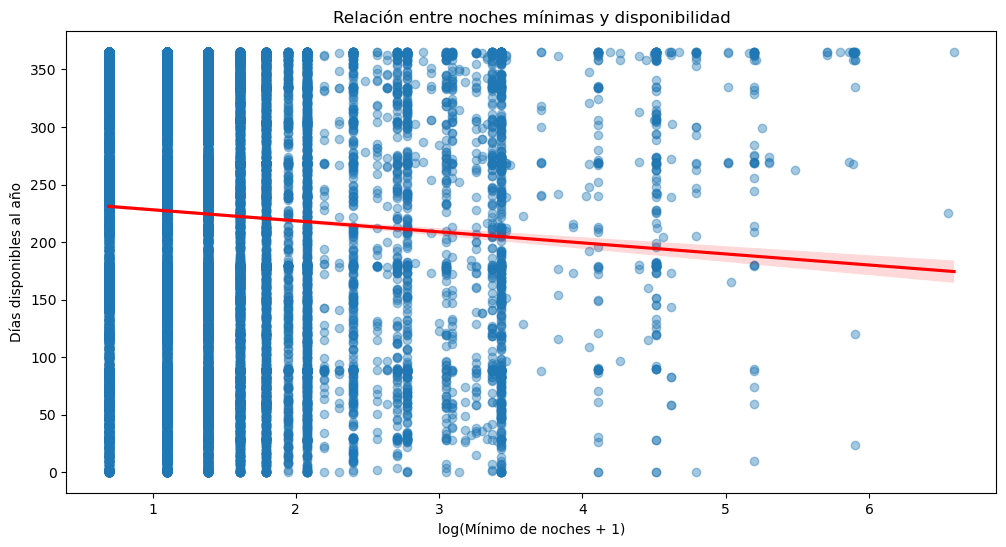

In [15]:
plt.figure(figsize=(12, 6))
# sns.scatterplot(x='min_nights_log', y='availability_365', data=df_fe, alpha=0.4)
sns.regplot(
    x='min_nights_log', 
    y='availability_365', 
    data=df_fe,
    scatter_kws={'alpha': 0.4},
    line_kws={'color': 'red'})
plt.title('Relación entre noches mínimas y disponibilidad')
plt.xlabel('log(Mínimo de noches + 1)')
plt.ylabel('Días disponibles al año')
plt.show()

Aunque se observa una ligera pendiente negativa en la línea de regresión, la dispersión de los puntos es muy alta y no hay una tendencia clara que indique una relación sistemática entre el mínimo de noches requeridas y la disponibilidad anual.

Esto sugiere que no existe una relación significativa ni relevante entre ambas variables, al menos de forma lineal o monótona.

En otras palabras, los cambios en el mínimo de noches no parecen tener un impacto predecible sobre cuántos días al año está disponible un alojamiento.

In [16]:
from scipy.stats import spearmanr

rho, p = spearmanr(df_fe['min_nights_log'], df_fe['availability_365'])
print(f"Spearman rho={rho:.2f}, p={p:.4f}")


Spearman rho=-0.11, p=0.0000


El test Spearman refuerza la conclusión al estar $\rho$ cerca de cero.

###  3. Inferencia estadística

* ¿El precio promedio difiere según el tipo de habitación?

H0: El precio promedio es igual entre los diferentes tipos de habitación.

H1: Al menos un tipo de habitación tiene un precio promedio diferente.

In [17]:
from scipy.stats import f_oneway

groups = [df_fe[df_fe['room_type'] == cat]['price'] for cat in df_fe['room_type'].unique()]
cant = len(groups)           # Cuántos grupos (tipos de habitación) hay
print(f'La cantidad de tipos de habitación es {cant}')

f_stat, p = f_oneway(*groups)
print(f"ANOVA - Precio vs Tipo de habitación: F={f_stat:.2f}, p={p:.4f}")

if p <= 0.05:
    print("Rechazamos H0: hay diferencias significativas en el precio según tipo de habitación.")
else:
    print("No rechazamos H0: no hay diferencias significativas.")




La cantidad de tipos de habitación es 4
ANOVA - Precio vs Tipo de habitación: F=403.65, p=0.0000
Rechazamos H0: hay diferencias significativas en el precio según tipo de habitación.


* ¿Los alojamientos que permiten reserva instantánea tienen un precio diferente que los que no?

H0: El precio promedio es igual entre alojamientos con y sin reserva instantánea.

H1: El precio promedio es diferente entre los dos grupos.

In [18]:
from scipy.stats import ttest_ind

instant = df_fe[df_fe['instant_bookable'] == True]['price']
not_instant = df_fe[df_fe['instant_bookable'] == False]['price']

t_stat, p = ttest_ind(instant, not_instant, equal_var=False)

print(f"Test-t - Precio vs Reserva instantánea: t={t_stat:.2f}, p={p:.4f}")

if p <= 0.05:
    print("Rechazamos H0: los precios difieren según si permite reserva instantánea.")
else:
    print("No rechazamos H0: no hay diferencia significativa en los precios.")


Test-t - Precio vs Reserva instantánea: t=-1.23, p=0.2205
No rechazamos H0: no hay diferencia significativa en los precios.


* ¿Los alojamientos altamente comentados tienen mejor puntaje?

H0: no hay diferencia en la media de review_scores_rating para highly_reviewed = 1 y 0.

H1: hay diferencia entre la media de review_scores_rating para los alojamientos altamente comentados y los que no son tan comentados.

In [19]:
from scipy.stats import ttest_ind

high = df_fe[df_fe['highly_reviewed'] == 1]['review_scores_rating']
low = df_fe[df_fe['highly_reviewed'] == 0]['review_scores_rating']

t_stat, p = ttest_ind(high.dropna(), low.dropna(), equal_var=False)
print(f"Test-t - Puntaje según 'highly_reviewed': t={t_stat:.2f}, p={p:.10e}")

if p <= 0.05:
    print("Rechazamos H0: concluimos que la cantidad de comentarios tiene un impacto en la puntuación promedio.")
else:
    print("No rechazamos H0: no hay evidencia de que haya diferencias (la cantidad de comentarios no afecta la posición).")

Test-t - Puntaje según 'highly_reviewed': t=14.16, p=4.0015822747e-45
Rechazamos H0: concluimos que la cantidad de comentarios tiene un impacto en la puntuación promedio.


* ¿La disponibilidad anual (availability_365) se relaciona con el tipo de propiedad (property_type)?

H0: La disponibilidad promedio es igual entre los diferentes tipos de propiedad.

H1: Al menos un tipo de propiedad tiene una disponibilidad significativamente diferente.

In [20]:
groups = [df_fe[df_fe['property_type'] == cat]['availability_365'] for cat in df_fe['property_type'].unique()]
cant = len(groups)           # Cuántos grupos (tipos de propiedad) hay
print(f'La cantidad de tipos de propiedad es {cant}')   

f_stat, p = f_oneway(*groups)

print(f"ANOVA - Disponibilidad vs Tipo de propiedad: F={f_stat:.2f}, p={p:.10e}")

if p <= 0.05:
    print("Rechazamos H0: la disponibilidad difiere según el tipo de propiedad.")
else:
    print("No rechazamos H0: no hay diferencias en la disponibilidad.")


La cantidad de tipos de propiedad es 63
ANOVA - Disponibilidad vs Tipo de propiedad: F=2.78, p=2.8706304470e-12
Rechazamos H0: la disponibilidad difiere según el tipo de propiedad.


* ¿Los alojamientos con estancias mínimas más largas tienden a tener precios más altos?

H0: No hay correlación entre la cantidad mínima de noches y el precio.

H1: Existe una correlación significativa entre estas variables.

In [21]:
from scipy.stats import spearmanr

rho, p = spearmanr(df_fe['minimum_nights'], df_fe['price'])

print(f"Correlación Spearman - Mínimo de noches vs Precio: rho={rho:.2f}, p-value={p:.4f}")

if (p <= 0.05) and (rho > 0.7):
    print("Rechazamos H0: existe una correlación entre mínimo de noches y precio.")
else:
    print("No rechazamos H0: no hay evidencia de correlación.")


Correlación Spearman - Mínimo de noches vs Precio: rho=0.01, p-value=0.0429
No rechazamos H0: no hay evidencia de correlación.


En este caso, el $ \rho $ indica que no hay correlación fuerte